In [1]:
#  === Workspace preparation ===

# import packages 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from collections import Counter

import scipy 
from scipy import stats


import csv
import os
import datetime as dt
import yfinance as yf

# NLTK VADER for sentiment analysis
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn import preprocessing
from sklearn.linear_model import LinearRegression

# granger causality analysis 
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.stattools import adfuller

# Vector Autoregression Model
from statsmodels.tsa.api import VAR
from statsmodels.tsa.api import VARMAX
from statsmodels.tsa.api import AutoReg

In [2]:
%who

AutoReg	 Counter	 LinearRegression	 SentimentIntensityAnalyzer	 VAR	 VARMAX	 adfuller	 csv	 dt	 
grangercausalitytests	 np	 os	 pd	 plt	 preprocessing	 scipy	 sm	 sns	 
stats	 yf	 


In [3]:
import types
def imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            yield val.__name__
list(imports())

['builtins',
 'builtins',
 'pandas',
 'numpy',
 'matplotlib.pyplot',
 'seaborn',
 'scipy',
 'scipy.stats',
 'csv',
 'os',
 'datetime',
 'yfinance',
 'sklearn.preprocessing',
 'statsmodels.api',
 'types']

# Business Understanding
In the following analysis I am going to exmaine whether there is a relation betweet the public sentiment expressed on twitter regarding certain stocks and the actual stock price. 
The following stocks are part of this analysis: Apple, Amazon, Microsoft, Tesla 

***

# Data Understanding

This dataset was first published in a paper at the 2020 IEEE International Conference on Big Data under the 6th Special Session on Intelligent Data Mining track. I checked also their scraping code and contacted one of the authors in order to verifiy it's credibility. 

*** 
source: https://www.kaggle.com/omermetinn/tweets-about-the-top-companies-from-2015-to-2020

source: https://github.com/omer-metin/TweetCollector

source: https://www.yahoofinanceapi.com/gclid=CjwKCAjwx8iIBhBwEiwA2quaq7mzIHmf8CJmSk8z6KJnUUQrZd_oBF_OllZXKRwDT1BCrJGYHJpNVxoCg0AQAvD_BwE

source: https://ieeexplore.ieee.org/document/9378170

# Data Import  

In [4]:
#  === Tweets ===
tweets = pd.read_csv("/Users/pietj.ginski/Desktop/BWL-Studium/BWL 6 Semester/Bachelor Thesis/Raw Data BT/archive-2/Kaggle/Tweet.csv")

#
tweets['date_s'] = pd.to_datetime(tweets.post_date,unit='s').dt.strftime('%d-%m-%Y')

# convert to date 
tweets.date_s = pd.to_datetime(tweets.date_s)

# filter for more popular tweets 
# tweets = tweets[tweets['retweet_num']>3]

In [5]:
# check data 
tweets.head()

,tweet_id,writer,post_date,body,comment_num,retweet_num,like_num,date_s
0,550441509175443456,VisualStockRSRC,1420070457,"lx21 made $10,008 on $AAPL -Check it out! htt...",0,0,1,2015-01-01
1,550441672312512512,KeralaGuy77,1420070496,Insanity of today weirdo massive selling. $aap...,0,0,0,2015-01-01
2,550441732014223360,DozenStocks,1420070510,S&P100 #Stocks Performance $HD $LOW $SBUX $TGT...,0,0,0,2015-01-01
3,550442977802207232,ShowDreamCar,1420070807,$GM $TSLA: Volkswagen Pushes 2014 Record Recal...,0,0,1,2015-01-01
4,550443807834402816,i_Know_First,1420071005,Swing Trading: Up To 8.91% Return In 14 Days h...,0,0,1,2015-01-01


In [6]:
# how many indiviudal writers? and how many tweets?
print('I collected',tweets['tweet_id'].count(), 'tweets from', tweets['writer'].nunique(), 'unique writers.')

I collected 3717964 tweets from 140131 unique writers.


In [7]:
# convert to date and create date columns  
tweets['date'] = pd.to_datetime(tweets.post_date,unit='s').dt.strftime('%d-%m-%Y %H:%M:%S')
tweets['weekday'] = pd.to_datetime(tweets.post_date,unit='s').dt.strftime('%a')
tweets['year'] = pd.to_datetime(tweets.post_date,unit='s').dt.strftime('%Y')

In [8]:
#  === Company_Tweet ===
company_tweets = pd.read_csv("/Users/pietj.ginski/Desktop/BWL-Studium/BWL 6 Semester/Bachelor Thesis/Raw Data BT/archive-2/Kaggle/Company_Tweet.csv")

# check data 
company_tweets.head()

,tweet_id,ticker_symbol
0,550803612197457920,AAPL
1,550803610825928706,AAPL
2,550803225113157632,AAPL
3,550802957370159104,AAPL
4,550802855129382912,AAPL


In [9]:
# merge the two datasets
tweets_merged = pd.merge(company_tweets, tweets, on='tweet_id', how='inner')

# check data 
tweets_merged.tail()

,tweet_id,ticker_symbol,writer,post_date,body,comment_num,retweet_num,like_num,date_s,date,weekday,year
4336440,1212158772015034369,TSLA,StockJoke,1577836146,"I'm getting wasted on NYE, and thanks to @NHTS...",0,0,0,2019-12-31,31-12-2019 23:49:06,Tue,2019
4336441,1212159099632267268,TSLA,sweetog76,1577836224,$TSLA Very Interesting dude:,0,0,0,2019-12-31,31-12-2019 23:50:24,Tue,2019
4336442,1212159184931717120,TSLA,MelaynaLokosky,1577836245,If only 2020 brought more self-awareness to Te...,0,1,0,2019-12-31,31-12-2019 23:50:45,Tue,2019
4336443,1212159838882533376,TSLA,ShortingIsFun,1577836401,In 2020 I may start Tweeting out positive news...,0,0,1,2019-12-31,31-12-2019 23:53:21,Tue,2019
4336444,1212160015332728833,TSLA,Commuternyc,1577836443,Patiently Waiting for the no twitter sitter tw...,0,0,5,2019-12-31,31-12-2019 23:54:03,Tue,2019


In [10]:
#  === Stock Data ===

In [11]:
# *** Stock Data Function ***

def yahoo(ticker, start_date, end_date, df_name):

# define the ticker symbol
    tickerSymbol = ticker

# get data on this ticker
    tickerData = yf.Ticker(tickerSymbol)

# get the historical prices for this ticker
    df_name = tickerData.history(period='1d', start=start_date, end=end_date)

# get daily returns
    df_name["daily_returns"] = df_name["Close"].pct_change()

# convert index to date_s colums
    df_name['date_s'] = pd.to_datetime(df_name.index)
    
    return df_name

In [12]:
# apple stock data
apple_p = yahoo('AAPL','2015-12-31','2018-12-31','apple_p')

# amazon stock data 
amazon_p = yahoo('AMZN','2015-12-31','2018-12-31','amazon_p')

# microsoft stock data 
microsoft_p = yahoo('MSFT','2015-12-31','2018-12-31','microsoft_p')

# tesla stock data 
tesla_p = yahoo('TSLA','2015-12-31','2018-12-31','tesla_p')

In [13]:
print(apple_p.head(), amazon_p.head(), microsoft_p.head(), tesla_p.head())

                 Open       High        Low      Close     Volume  Dividends  \
Date                                                                           
2015-12-30  25.031456  25.059119  24.708707  24.740982  100855200        0.0   
2015-12-31  24.669518  24.674128  24.164647  24.266083  163649200        0.0   
2016-01-04  23.655166  24.291443  23.514540  24.286831  270597600        0.0   
2016-01-05  24.379047  24.402100  23.609061  23.678221  223164000        0.0   
2016-01-06  23.182567  23.599836  23.023499  23.214842  273829600        0.0   

            Stock Splits  daily_returns     date_s  
Date                                                
2015-12-30             0            NaN 2015-12-30  
2015-12-31             0      -0.019195 2015-12-31  
2016-01-04             0       0.000855 2016-01-04  
2016-01-05             0      -0.025059 2016-01-05  
2016-01-06             0      -0.019570 2016-01-06                     Open        High         Low       Close   Volume 

# Data Inspection and Visualisation

## Distribution of ø Retweets, Comment, Likes 

In [14]:
# Distribution of Retweets 
r = pd.DataFrame(tweets['retweet_num'].groupby(tweets['writer']).agg('mean').sort_values())

influencer = r[r['retweet_num']>=4]

not_influencer = r[r['retweet_num']<4]

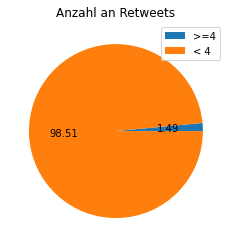

In [15]:
plt.pie((len(influencer),len(not_influencer)),autopct='%.2f')
plt.legend(['>=4','< 4'])
plt.title('Anzahl an Retweets')

plt.savefig("retweet.png", dpi=460)

In [16]:
# Distribution of Comments 
c = pd.DataFrame(tweets['comment_num'].groupby(tweets['writer']).agg('mean').sort_values())

influencer = c[c['comment_num']>=4]

not_influencer = c[c['comment_num']<4]

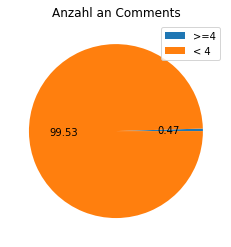

In [17]:
plt.pie((len(influencer),len(not_influencer)),autopct='%.2f')
plt.legend(['>=4','< 4'])
plt.title('Anzahl an Comments')

plt.savefig("comment.png", dpi=460)

In [18]:
# Distribution of Like 
l = pd.DataFrame(tweets['like_num'].groupby(tweets['writer']).agg('mean').sort_values())

influencer = l[l['like_num']>=4]

not_influencer = l[l['like_num']<4]

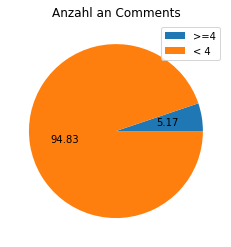

In [19]:
plt.pie((len(influencer),len(not_influencer)),autopct='%.2f')
plt.legend(['>=4','< 4'])
plt.title('Anzahl an Comments')

plt.savefig("comment.png", dpi=460)

## Most frequent Writers 

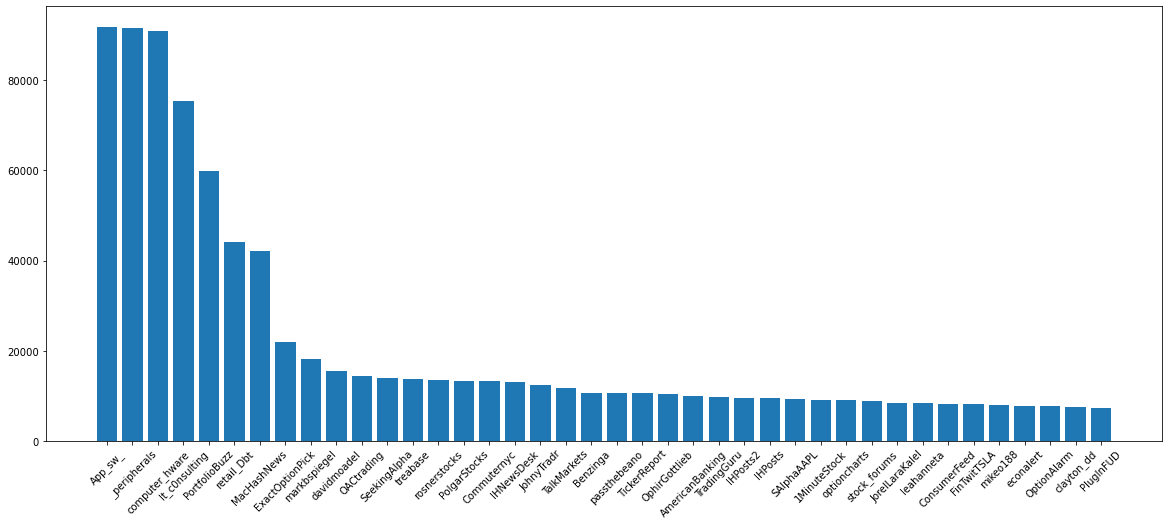

In [20]:
# top 40 most frequent writers
a = tweets['tweet_id'].groupby(tweets['writer']).nunique().sort_values(ascending=False).index[:40]
b = tweets['tweet_id'].groupby(tweets['writer']).nunique().sort_values(ascending=False)[:40]

plt.figure(figsize = (20, 8))
plt.xticks(rotation=45)
plt.bar(a,b)
plt.show()

In [21]:
count = 0 
mean = tweets['tweet_id'].groupby(tweets['writer']).nunique().mean()

for i in tweets['tweet_id'].groupby(tweets['writer']).nunique():
    if i>mean:
        count = count + 1

print(round(count/tweets['writer'].nunique(), 3))

0.071


## Weekly Trends 

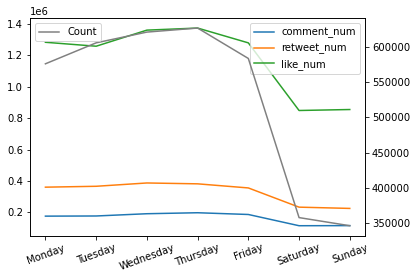

In [22]:
# evolution of unique tweets per weekday 
x = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']


fig, ax1 = plt.subplots()

ax1.plot(x, tweets['comment_num'].groupby(tweets['date_s'].dt.weekday).agg('sum'))
ax1.plot(x, tweets['retweet_num'].groupby(tweets['date_s'].dt.weekday).agg('sum'))
ax1.plot(x, tweets['like_num'].groupby(tweets['date_s'].dt.weekday).agg('sum'))
ax1.legend(['comment_num', 'retweet_num', 'like_num'], loc = 'upper right',bbox_to_anchor=(1.0, 1))
plt.xticks(rotation=20)

ax2 = ax1.twinx()
ax2.plot(x, tweets['tweet_id'].groupby(tweets['date_s'].dt.weekday).agg('count'), color = 'grey')
ax2.legend(['Count'], loc = 'upper left')

plt.show()

## Total Number of Unique Tweets 

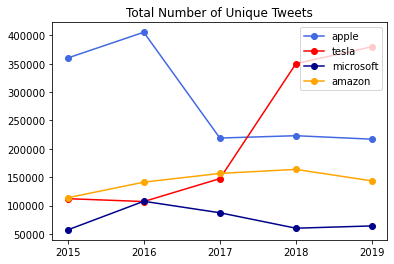

In [23]:
# check amount of unique tweets
ap = tweets_merged[tweets_merged['ticker_symbol'] == 'AAPL']['tweet_id'].groupby(tweets_merged['date_s'].dt.year).agg('count')
ts = tweets_merged[tweets_merged['ticker_symbol'] == 'TSLA']['tweet_id'].groupby(tweets_merged['date_s'].dt.year).agg('count')
ms = tweets_merged[tweets_merged['ticker_symbol'] == 'MSFT']['tweet_id'].groupby(tweets_merged['date_s'].dt.year).agg('count')
az = tweets_merged[tweets_merged['ticker_symbol'] == 'AMZN']['tweet_id'].groupby(tweets_merged['date_s'].dt.year).agg('count')

year = ['2015','2016','2017','2018','2019']

plt.plot(year,ap,
        color = 'royalblue', marker='o')
plt.plot(year,ts,
        color = 'red', marker='o')
plt.plot(year,ms,
        color = 'darkblue', marker='o')
plt.plot(year,az,
        color = 'orange', marker='o')
plt.legend(['apple', 'tesla','microsoft','amazon'], loc='upper right')
plt.title('Total Number of Unique Tweets')
plt.show()

## Average Comment, Retweet, Like per Unique Tweet

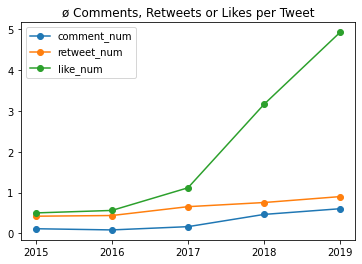

In [24]:
# check ø comment_num, retweet_num and like_num

comment_share_year = tweets_merged['comment_num'].groupby(tweets_merged['date_s'].dt.year).agg('sum')/tweets_merged['tweet_id'].groupby(tweets_merged['date_s'].dt.year).agg('count')
retweet_share_year = tweets_merged['retweet_num'].groupby(tweets_merged['date_s'].dt.year).agg('sum')/tweets_merged['tweet_id'].groupby(tweets_merged['date_s'].dt.year).agg('count')
likes_share_year = tweets_merged['like_num'].groupby(tweets_merged['date_s'].dt.year).agg('sum')/ tweets_merged['tweet_id'].groupby(tweets_merged['date_s'].dt.year).agg('count')


plt.plot(year,comment_share_year, marker='o')
plt.plot(year,retweet_share_year, marker='o')
plt.plot(year,likes_share_year, marker='o')
plt.legend(['comment_num','retweet_num','like_num'])
plt.title('ø Comments, Retweets or Likes per Tweet')
plt.show()



## Average Comment per Unique Tweet

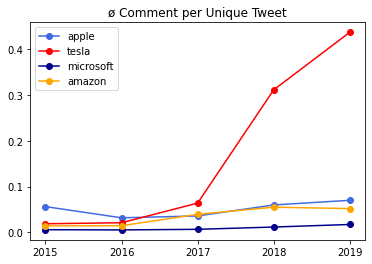

In [25]:
# ø Comment per Unique Tweet
ap = tweets_merged[tweets_merged['ticker_symbol'] == 'AAPL']['comment_num'].groupby(tweets_merged['date_s'].dt.year).agg('sum')/tweets_merged['tweet_id'].groupby(tweets_merged['date_s'].dt.year).agg('count')
ts = tweets_merged[tweets_merged['ticker_symbol'] == 'TSLA']['comment_num'].groupby(tweets_merged['date_s'].dt.year).agg('sum')/tweets_merged['tweet_id'].groupby(tweets_merged['date_s'].dt.year).agg('count')
ms = tweets_merged[tweets_merged['ticker_symbol'] == 'MSFT']['comment_num'].groupby(tweets_merged['date_s'].dt.year).agg('sum')/tweets_merged['tweet_id'].groupby(tweets_merged['date_s'].dt.year).agg('count')
az = tweets_merged[tweets_merged['ticker_symbol'] == 'AMZN']['comment_num'].groupby(tweets_merged['date_s'].dt.year).agg('sum')/tweets_merged['tweet_id'].groupby(tweets_merged['date_s'].dt.year).agg('count')

# month = ['Jan','Feb','Mar','Apr','Mai','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

plt.plot(year,ap,
        color = 'royalblue', marker='o')
plt.plot(year,ts,
        color = 'red', marker='o')
plt.plot(year,ms,
        color = 'darkblue', marker='o')
plt.plot(year,az,
        color = 'orange', marker='o')
plt.legend(['apple', 'tesla','microsoft','amazon'], loc='upper left')
plt.title('ø Comment per Unique Tweet')
plt.show()

> __Tesla became a very hot topic over the years.__

## Average Retweet per Unique Tweet

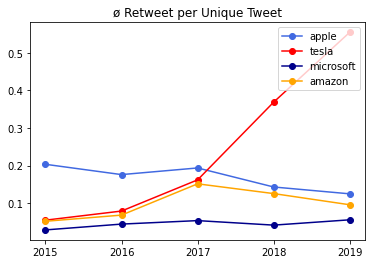

In [26]:
# check amount of unique tweets
ap = tweets_merged[tweets_merged['ticker_symbol'] == 'AAPL']['retweet_num'].groupby(tweets_merged['date_s'].dt.year).agg('sum')/tweets_merged['tweet_id'].groupby(tweets_merged['date_s'].dt.year).agg('count')
ts = tweets_merged[tweets_merged['ticker_symbol'] == 'TSLA']['retweet_num'].groupby(tweets_merged['date_s'].dt.year).agg('sum')/tweets_merged['tweet_id'].groupby(tweets_merged['date_s'].dt.year).agg('count')
ms = tweets_merged[tweets_merged['ticker_symbol'] == 'MSFT']['retweet_num'].groupby(tweets_merged['date_s'].dt.year).agg('sum')/tweets_merged['tweet_id'].groupby(tweets_merged['date_s'].dt.year).agg('count')
az = tweets_merged[tweets_merged['ticker_symbol'] == 'AMZN']['retweet_num'].groupby(tweets_merged['date_s'].dt.year).agg('sum')/tweets_merged['tweet_id'].groupby(tweets_merged['date_s'].dt.year).agg('count')

# month = ['Jan','Feb','Mar','Apr','Mai','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

plt.plot(year,ap,
        color = 'royalblue', marker='o')
plt.plot(year,ts,
        color = 'red', marker='o')
plt.plot(year,ms,
        color = 'darkblue', marker='o')
plt.plot(year,az,
        color = 'orange', marker='o')
plt.legend(['apple', 'tesla','microsoft','amazon'], loc='upper right')
plt.title('ø Retweet per Unique Tweet')
plt.show()

## Average Like per Unique Tweet

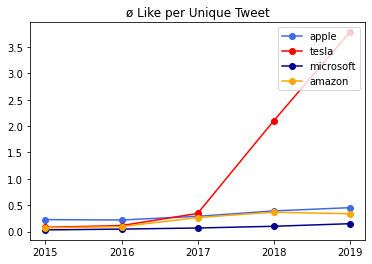

In [27]:
# check amount of unique tweets
ap = tweets_merged[tweets_merged['ticker_symbol'] == 'AAPL']['like_num'].groupby(tweets_merged['date_s'].dt.year).agg('sum')/tweets_merged['tweet_id'].groupby(tweets_merged['date_s'].dt.year).agg('count')
ts = tweets_merged[tweets_merged['ticker_symbol'] == 'TSLA']['like_num'].groupby(tweets_merged['date_s'].dt.year).agg('sum')/tweets_merged['tweet_id'].groupby(tweets_merged['date_s'].dt.year).agg('count')
ms = tweets_merged[tweets_merged['ticker_symbol'] == 'MSFT']['like_num'].groupby(tweets_merged['date_s'].dt.year).agg('sum')/tweets_merged['tweet_id'].groupby(tweets_merged['date_s'].dt.year).agg('count')
az = tweets_merged[tweets_merged['ticker_symbol'] == 'AMZN']['like_num'].groupby(tweets_merged['date_s'].dt.year).agg('sum')/tweets_merged['tweet_id'].groupby(tweets_merged['date_s'].dt.year).agg('count')

# month = ['Jan','Feb','Mar','Apr','Mai','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

plt.plot(year,ap,
        color = 'royalblue', marker='o')
plt.plot(year,ts,
        color = 'red', marker='o')
plt.plot(year,ms,
        color = 'darkblue', marker='o')
plt.plot(year,az,
        color = 'orange', marker='o')
plt.legend(['apple', 'tesla','microsoft','amazon'], loc='upper right')
plt.title('ø Like per Unique Tweet')
plt.show()

In [28]:
# delete dataset 
del company_tweets
del tweets

In [29]:
for f, b in zip(Counter(tweets_merged['ticker_symbol']).keys(), Counter(tweets_merged['ticker_symbol']).values()):
    print(f,'Proportion of Dataset:', round(b/len(tweets_merged), 2), '%')

AAPL Proportion of Dataset: 0.33 %
AMZN Proportion of Dataset: 0.17 %
GOOGL Proportion of Dataset: 0.08 %
TSLA Proportion of Dataset: 0.25 %
GOOG Proportion of Dataset: 0.09 %
MSFT Proportion of Dataset: 0.09 %


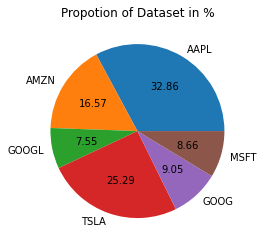

In [30]:
# display distribution in pie chart 
list_x = []
for i in Counter(tweets_merged['ticker_symbol']).values():
             list_x.append(i/len(tweets_merged))

# plot 
plt.pie(list_x, labels = Counter(tweets_merged['ticker_symbol']).keys(), autopct='%1.2f',)
plt.title('Propotion of Dataset in %')
plt.show() 

In [31]:
# Preprocessing

# # remove $ 
# tweets_merged['new_body'] = tweets_merged['body'].str.replace('($\w+.*?)',"")

# # remove $ 
# tweets_merged['new_body'] = tweets_merged['new_body'].str.replace('(\$\w+.*?)',"")

# # remove @ 
# tweets_merged['new_body'] = tweets_merged['new_body'].str.replace('(@\w+.*?)',"")

# # remove @ 
# tweets_merged['new_body'] = tweets_merged['new_body'].str.replace('(\@\w+.*?)',"")

# # remove urls  
# tweets_merged['new_body'] = tweets_merged['new_body'].str.replace('((https?):((//)|(\\\\))+([\w\d:#@%/;$()~_?\+-=\\\.&](#!)?)*)',"")

# # check data 
# tweets_merged['new_body'].tail()

In [34]:
# check data - index 20 has hashtags, links and mentions in one text
# tweets_merged['new_body'][20]

# Data Modeling 

In [38]:
#  === VADER ===

# create the analyzer 
analyzer = SentimentIntensityAnalyzer()

# prepare the data
sentences = np.array(tweets_merged["body"])

# get the vader scores 
tweets_merged['vader_scores'] = tweets_merged['body'].apply(lambda sentences: analyzer.polarity_scores(sentences))

# append vader_scores 
tweets_merged['compound'] = tweets_merged['vader_scores'].apply(lambda score_dict: score_dict['compound'])

# check data
tweets_merged.head()

,tweet_id,ticker_symbol,writer,post_date,body,comment_num,retweet_num,like_num,date_s,date,weekday,year,vader_scores,compound
0,550803612197457920,AAPL,SentiQuant,1420156789,#TOPTICKERTWEETS $AAPL $IMRS $BABA $EBAY $AMZN...,0,0,1,2015-01-01,01-01-2015 23:59:49,Thu,2015,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0
1,550803612197457920,AMZN,SentiQuant,1420156789,#TOPTICKERTWEETS $AAPL $IMRS $BABA $EBAY $AMZN...,0,0,1,2015-01-01,01-01-2015 23:59:49,Thu,2015,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0
2,550803610825928706,AAPL,SentiQuant,1420156788,#SENTISHIFTUP $K $FB $GOOGL $GS $GOLD $T $AAPL...,0,0,1,2015-01-01,01-01-2015 23:59:48,Thu,2015,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0
3,550803610825928706,GOOGL,SentiQuant,1420156788,#SENTISHIFTUP $K $FB $GOOGL $GS $GOLD $T $AAPL...,0,0,1,2015-01-01,01-01-2015 23:59:48,Thu,2015,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0
4,550803610825928706,AMZN,SentiQuant,1420156788,#SENTISHIFTUP $K $FB $GOOGL $GS $GOLD $T $AAPL...,0,0,1,2015-01-01,01-01-2015 23:59:48,Thu,2015,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0


In [39]:
#  === Engagement Score ===
# creating a sensible engagement score through normalization
x = tweets_merged[['comment_num','retweet_num','like_num']].values 
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled)
engagement_score = df[0]+df[1]+df[2]

# === Approval Score ===
x2 = tweets_merged[['retweet_num','like_num']].values 
x2_scaled = min_max_scaler.fit_transform(x2)
df2 = pd.DataFrame(x2_scaled)
approval_score = df2[0]+df2[1]

# === Controversial Score === 
x3 = tweets_merged[['comment_num']].values 
x3_scaled = min_max_scaler.fit_transform(x3)
df3 = pd.DataFrame(x3_scaled)
controversial_score = df3[0]

# append engagement_score & compound_engagement_score
tweets_merged['engagement_score'] = engagement_score
tweets_merged['approval_score'] = approval_score
tweets_merged['controversial_score'] = controversial_score

# creating the combined compound metric
tweets_merged['compound_engagement_score'] = tweets_merged['engagement_score']*tweets_merged['compound']
tweets_merged['compound_approval_score'] = tweets_merged['approval_score']*tweets_merged['compound']
tweets_merged['compound_controversial_score'] = tweets_merged['controversial_score']*tweets_merged['compound']
tweets_merged.head()

,tweet_id,ticker_symbol,writer,post_date,body,comment_num,retweet_num,like_num,date_s,date,weekday,year,vader_scores,compound,engagement_score,approval_score,controversial_score,compound_engagement_score,compound_approval_score,compound_controversial_score
0,550803612197457920,AAPL,SentiQuant,1420156789,#TOPTICKERTWEETS $AAPL $IMRS $BABA $EBAY $AMZN...,0,0,1,2015-01-01,01-01-2015 23:59:49,Thu,2015,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0,0.001001,0.001001,0.0,0.0,0.0,0.0
1,550803612197457920,AMZN,SentiQuant,1420156789,#TOPTICKERTWEETS $AAPL $IMRS $BABA $EBAY $AMZN...,0,0,1,2015-01-01,01-01-2015 23:59:49,Thu,2015,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0,0.001001,0.001001,0.0,0.0,0.0,0.0
2,550803610825928706,AAPL,SentiQuant,1420156788,#SENTISHIFTUP $K $FB $GOOGL $GS $GOLD $T $AAPL...,0,0,1,2015-01-01,01-01-2015 23:59:48,Thu,2015,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0,0.001001,0.001001,0.0,0.0,0.0,0.0
3,550803610825928706,GOOGL,SentiQuant,1420156788,#SENTISHIFTUP $K $FB $GOOGL $GS $GOLD $T $AAPL...,0,0,1,2015-01-01,01-01-2015 23:59:48,Thu,2015,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0,0.001001,0.001001,0.0,0.0,0.0,0.0
4,550803610825928706,AMZN,SentiQuant,1420156788,#SENTISHIFTUP $K $FB $GOOGL $GS $GOLD $T $AAPL...,0,0,1,2015-01-01,01-01-2015 23:59:48,Thu,2015,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0,0.001001,0.001001,0.0,0.0,0.0,0.0


# Data Analysis

### Apple Analysis

In [40]:
# group sentiment by date - APPLE ONLY
tweets_merged_grouped_apple_a = tweets_merged[tweets_merged['ticker_symbol']=='AAPL'].groupby(pd.to_datetime(tweets_merged['date_s']).dt.date).mean()

# convert to datetime
apple_p.date_s = pd.to_datetime(apple_p.date_s)
tweets_merged_grouped_apple_a.index = pd.to_datetime(tweets_merged_grouped_apple_a.index)

# merge the two datasets
tweets_merged_grouped_apple = pd.merge(tweets_merged_grouped_apple_a, apple_p, on='date_s', how='inner')

In [41]:
# create column which contains the delta of the compound
tweets_merged_grouped_apple["delta_compound"] = tweets_merged_grouped_apple["compound"].pct_change()

# check data 
tweets_merged_grouped_apple.head()

,date_s,tweet_id,post_date,comment_num,retweet_num,like_num,compound,engagement_score,approval_score,controversial_score,...,compound_controversial_score,Open,High,Low,Close,Volume,Dividends,Stock Splits,daily_returns,delta_compound
0,2015-12-30,6.822098e+17,1.451486e+09,0.127389,0.496815,0.668790,0.065459,0.001369,0.001167,0.000202,...,0.000001,25.031456,25.059119,24.708707,24.740982,100855200,0.0,0,NaN,NaN
1,2015-12-31,6.825770e+17,1.451574e+09,0.114843,0.317443,0.526544,0.049655,0.001027,0.000845,0.000182,...,0.000013,24.669518,24.674128,24.164647,24.266083,163649200,0.0,0,-0.019195,-0.241428
2,2016-01-04,7.159234e+17,1.459524e+09,0.069507,0.393871,0.482063,0.111370,0.000987,0.000877,0.000110,...,0.000009,23.655166,24.291443,23.514540,24.286831,270597600,0.0,0,0.000855,1.242863
3,2016-01-05,7.267843e+17,1.462114e+09,0.080103,0.633075,0.697674,0.066172,0.001459,0.001332,0.000127,...,0.000012,24.379047,24.402100,23.609061,23.678221,223164000,0.0,0,-0.025059,-0.405840
4,2016-01-06,7.380149e+17,1.464791e+09,0.057726,0.309059,0.339254,0.054101,0.000740,0.000649,0.000091,...,0.000010,23.182567,23.599836,23.023499,23.214842,273829600,0.0,0,-0.019570,-0.182408


> General idea: % ∆ Sentiment => % ∆ Returns 

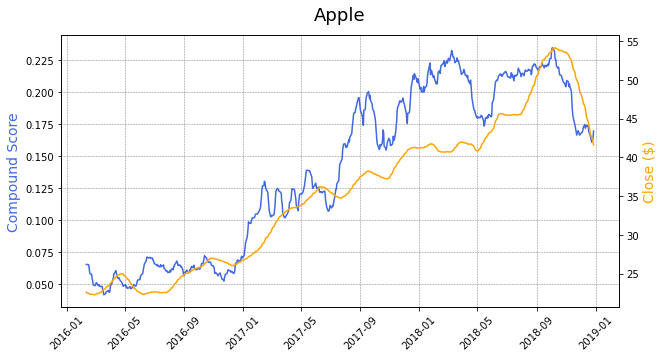

In [42]:
# plot tweets_merged_grouped 
fig,ax = plt.subplots(figsize = (10, 5))
ax.plot(tweets_merged_grouped_apple.date_s, 
        tweets_merged_grouped_apple['compound'].rolling(window=30).mean(),
        color = 'royalblue')
plt.grid(color = 'grey', linestyle = '--', linewidth = 0.5)
plt.xticks(rotation=45)
ax2 = ax.twinx()
ax2.plot(tweets_merged_grouped_apple['date_s'], 
            tweets_merged_grouped_apple['Close'].rolling(window=30).mean(),
            color = "orange")
# ax.set_xlabel('Date', fontsize=16)
ax.set_ylabel('Compound Score', color = 'royalblue', fontsize=14)
ax2.set_ylabel('Close ($)', color = 'orange', fontsize=14)
plt.title("Apple", fontsize=18, pad='15.0')

plt.savefig("Apple.png", dpi=460)

In [43]:
# check whether all variables are distributed normally

l = list(tweets_merged_grouped_apple.columns.values)[1:]
counter = -1
 
for i in l:
    x = stats.normaltest(tweets_merged_grouped_apple[i][1:])
    counter = counter + 1
    if x.pvalue < 0.05: 
        print(l[counter],x.pvalue.round(3), 'TRUE')
    else: 
        print(l[counter],x.pvalue.round(3), 'FALSE')

tweet_id 0.0 TRUE
post_date 0.0 TRUE
comment_num 0.0 TRUE
retweet_num 0.0 TRUE
like_num 0.0 TRUE
compound 0.0 TRUE
engagement_score 0.0 TRUE
approval_score 0.0 TRUE
controversial_score 0.0 TRUE
compound_engagement_score 0.0 TRUE
compound_approval_score 0.0 TRUE
compound_controversial_score 0.0 TRUE
Open 0.0 TRUE
High 0.0 TRUE
Low 0.0 TRUE
Close 0.0 TRUE
Volume 0.0 TRUE
Dividends 0.0 TRUE
Stock Splits 0.0 TRUE
daily_returns 0.0 TRUE
delta_compound 0.0 TRUE


In [44]:
# correlation analysis 
corr, p_value = scipy.stats.pearsonr(tweets_merged_grouped_apple["delta_compound"][1:], tweets_merged_grouped_apple["daily_returns"][1:])

print('Correlation Coefficient:',corr.round(3))
print('P-Value:',p_value.round(3))

Correlation Coefficient: -0.015
P-Value: 0.686


In [45]:
# correlation analysis 
corr, p_value = scipy.stats.pearsonr(tweets_merged_grouped_apple["compound"], tweets_merged_grouped_apple["Close"])

print('Correlation Coefficient:',corr.round(3))
print('P-Value:',p_value)

Correlation Coefficient: 0.73
P-Value: 1.3548871730993886e-126


In [46]:
# correlation analysis 
corr, p_value = scipy.stats.pearsonr(tweets_merged_grouped_apple["compound_engagement_score"], tweets_merged_grouped_apple["Close"])

print('Correlation Coefficient:',corr.round(3))
print('P-Value:',p_value)

Correlation Coefficient: 0.439
P-Value: 6.075015664897751e-37


In [47]:
# correlation analysis 
corr, p_value = scipy.stats.pearsonr(tweets_merged_grouped_apple["compound_approval_score"], tweets_merged_grouped_apple["Close"])

print('Correlation Coefficient:',corr.round(3))
print('P-Value:',p_value)

Correlation Coefficient: 0.419
P-Value: 1.8231293156157636e-33


In [48]:
# correlation analysis 
corr, p_value = scipy.stats.pearsonr(tweets_merged_grouped_apple["compound_controversial_score"], tweets_merged_grouped_apple["Close"])

print('Correlation Coefficient:',corr.round(3))
print('P-Value:',p_value)

Correlation Coefficient: 0.47
P-Value: 8.286934502251661e-43


#### Check for Lag 
Does the sentiment from the previous day predictive power for the next day's daily return?

In [49]:
# check for lag

# apple delta return (has to be one day ahead )
ap_dr = tweets_merged_grouped_apple["Close"].shift(2)[3:]
# apple delta compound 
ap_dc = tweets_merged_grouped_apple["compound"][3:]


# correlation analysis
corr, p_value = scipy.stats.pearsonr(ap_dc, ap_dr)

print('Correlation Coefficient:',corr.round(3))
print('P-Value:',p_value.round(3))

Correlation Coefficient: 0.722
P-Value: 0.0


#### Stationary Check

Augmented Dickey-Fuller test
Statistical tests make strong assumptions about your data. They can only be used to inform the degree to which a null hypothesis can be rejected or fail to be reject. The result must be interpreted for a given problem to be meaningful.

Nevertheless, they can provide a quick check and confirmatory evidence that your time series is stationary or non-stationary.

The Augmented Dickey-Fuller test is a type of statistical test called a unit root test.

The intuition behind a unit root test is that it determines how strongly a time series is defined by a trend.

There are a number of unit root tests and the Augmented Dickey-Fuller may be one of the more widely used. It uses an autoregressive model and optimizes an information criterion across multiple different lag values.

The null hypothesis of the test is that the time series can be represented by a unit root, that it is not stationary (has some time-dependent structure). The alternate hypothesis (rejecting the null hypothesis) is that the time series is stationary.

Null Hypothesis (H0): If failed to be rejected, it suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.
Alternate Hypothesis (H1): The null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure.
We interpret this result using the p-value from the test. A p-value below a threshold (such as 5% or 1%) suggests we reject the null hypothesis (stationary), otherwise a p-value above the threshold suggests we fail to reject the null hypothesis (non-stationary).

p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

In [50]:
# create stationary time series
stationary_close = tweets_merged_grouped_apple[["Close"]].pct_change().dropna().values
stationary_compound = tweets_merged_grouped_apple[["compound"]].pct_change().dropna().values

# print results for close
result_close = adfuller(stationary_close)
print('ADF Statistic: %f' % result_close[0])
print('p-value: %f' % result_close[1])
print('Critical Values:')
for key, value in result_close[4].items():
	print('\t%s: %.3f' % (key, value))
    
# print results for compound
result_compound = adfuller(stationary_compound)
print('ADF Statistic: %f' % result_compound[0])
print('p-value: %f' % result_compound[1])
print('Critical Values:')
for key, value in result_compound[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -26.017756
p-value: 0.000000
Critical Values:
	1%: -3.439
	5%: -2.865
	10%: -2.569
ADF Statistic: -27.566992
p-value: 0.000000
Critical Values:
	1%: -3.439
	5%: -2.865
	10%: -2.569


#### Ganger Causality Analysis 
The Null hypothesis for grangercausalitytests is that __the time series in the second column, x2, does NOT Granger cause the time series in the first column, x1__. Grange causality means that past values of x2 have a statistically significant effect on the current value of x1, taking past values of x1 into account as regressors. We reject the null hypothesis that x2 does not Granger cause x1 if the pvalues are below a desired size of the test.

In [51]:
# create data 
data = tweets_merged_grouped_apple[["Close", "compound"]].pct_change().dropna()
# execute granger causality test
gc_res = grangercausalitytests(data, 20)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5218  , p=0.4703  , df_denom=750, df_num=1
ssr based chi2 test:   chi2=0.5239  , p=0.4692  , df=1
likelihood ratio test: chi2=0.5237  , p=0.4693  , df=1
parameter F test:         F=0.5218  , p=0.4703  , df_denom=750, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.4059  , p=0.6665  , df_denom=747, df_num=2
ssr based chi2 test:   chi2=0.8172  , p=0.6646  , df=2
likelihood ratio test: chi2=0.8168  , p=0.6647  , df=2
parameter F test:         F=0.4059  , p=0.6665  , df_denom=747, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.1661  , p=0.3217  , df_denom=744, df_num=3
ssr based chi2 test:   chi2=3.5314  , p=0.3167  , df=3
likelihood ratio test: chi2=3.5231  , p=0.3178  , df=3
parameter F test:         F=1.1661  , p=0.3217  , df_denom=744, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.0673  , p=0.3716  

> For number of lags (no zero) __1__ when p-value shows up as p=0.4037, this means that past __1__ values of __"compound"__ (jointly) __have no statistically significant effect__ on the current value of the __"Close"__ column (first column).


> For number of lags (no zero) __14__ when p-value shows up as p=0.0003, this means that past __14__ values of "compound" (jointly) __have statistically significant effect__ on the current value of the "Close" column (first column).

In [52]:
# create data 
data = tweets_merged_grouped_apple[["compound", "Close"]].pct_change().dropna()
# execute granger causality test
gc_res = grangercausalitytests(data, 20)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.9564  , p=0.0085  , df_denom=750, df_num=1
ssr based chi2 test:   chi2=6.9842  , p=0.0082  , df=1
likelihood ratio test: chi2=6.9520  , p=0.0084  , df=1
parameter F test:         F=6.9564  , p=0.0085  , df_denom=750, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.7298  , p=0.0244  , df_denom=747, df_num=2
ssr based chi2 test:   chi2=7.5095  , p=0.0234  , df=2
likelihood ratio test: chi2=7.4723  , p=0.0238  , df=2
parameter F test:         F=3.7298  , p=0.0244  , df_denom=747, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.8957  , p=0.0089  , df_denom=744, df_num=3
ssr based chi2 test:   chi2=11.7970 , p=0.0081  , df=3
likelihood ratio test: chi2=11.7053 , p=0.0085  , df=3
parameter F test:         F=3.8957  , p=0.0089  , df_denom=744, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.0813  , p=0.0156  

> For number of lags (no zero) __1__ when p-value shows up as p=0.0085, this means that past __1__ values of __"Close"__ (jointly) __have statistically significant effect__ on the current value of the __"compound"__ column (first column).

### Amazon Analysis

In [53]:
# group sentiment by date - APPLE ONLY
tweets_merged_grouped_amazon_a = tweets_merged[tweets_merged['ticker_symbol']=='AMZN'].groupby(pd.to_datetime(tweets_merged['date_s']).dt.date).mean()

# convert to datetime
amazon_p.date_s = pd.to_datetime(amazon_p.date_s)
tweets_merged_grouped_amazon_a.index = pd.to_datetime(tweets_merged_grouped_amazon_a.index)

# merge the two datasets
tweets_merged_grouped_amazon = pd.merge(tweets_merged_grouped_amazon_a, amazon_p, on='date_s', how='inner')

In [54]:
# create column which contains the delta 
tweets_merged_grouped_amazon["delta_compound"] = tweets_merged_grouped_amazon["compound"].pct_change()
# check data 
tweets_merged_grouped_amazon.head()

,date_s,tweet_id,post_date,comment_num,retweet_num,like_num,compound,engagement_score,approval_score,controversial_score,...,compound_controversial_score,Open,High,Low,Close,Volume,Dividends,Stock Splits,daily_returns,delta_compound
0,2015-12-30,6.821796e+17,1.451479e+09,0.075980,0.475490,0.549020,0.139368,0.001146,0.001026,0.000120,...,0.000020,691.890015,695.489990,686.380005,689.070007,3519000,0,0,NaN,NaN
1,2015-12-31,6.825690e+17,1.451572e+09,0.081535,0.565947,0.633094,0.112760,0.001329,0.001200,0.000129,...,0.000028,686.080017,687.750000,675.890015,675.890015,3749600,0,0,-0.019127,-0.190917
2,2016-01-04,7.159171e+17,1.459523e+09,0.094118,0.223529,0.447059,0.083800,0.000820,0.000671,0.000149,...,0.000021,656.289978,657.719971,627.510010,636.989990,9314500,0,0,-0.057554,-0.256830
3,2016-01-05,7.267843e+17,1.462114e+09,0.067901,1.382716,1.537037,0.127110,0.003030,0.002923,0.000108,...,-0.000008,646.859985,646.909973,627.650024,633.789978,5822600,0,0,-0.005024,0.516824
4,2016-01-06,7.380116e+17,1.464791e+09,0.095841,0.396022,0.698011,0.111991,0.001247,0.001095,0.000152,...,0.000012,622.000000,639.789978,620.309998,632.650024,5329200,0,0,-0.001799,-0.118945


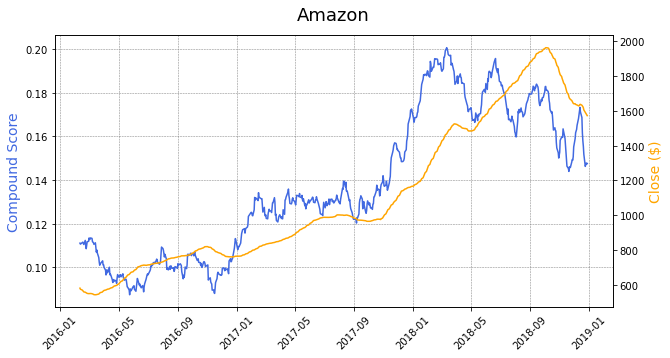

In [55]:
# plot tweets_merged_grouped 
fig,ax = plt.subplots(figsize = (10, 5))
ax.plot(tweets_merged_grouped_amazon.date_s, 
        tweets_merged_grouped_amazon['compound'].rolling(window=30).mean(),
        color = 'royalblue')
plt.grid(color = 'grey', linestyle = '--', linewidth = 0.5)
plt.xticks(rotation=45)
ax2 = ax.twinx()
ax2.plot(tweets_merged_grouped_amazon['date_s'], 
            tweets_merged_grouped_amazon['Close'].rolling(window=30).mean(),
            color = "orange")
# ax.set_xlabel('Date', fontsize=16)
ax.set_ylabel('Compound Score', color = 'royalblue', fontsize=14)
ax2.set_ylabel('Close ($)', color = 'orange', fontsize=14)
plt.title("Amazon", fontsize=18, pad='15.0')

plt.savefig("Amazon.png", dpi=460)

In [56]:
# check whether all variables are distributed normally

l = list(tweets_merged_grouped_amazon.columns.values)[1:]
counter = -1

for i in l:
    x = stats.normaltest(tweets_merged_grouped_amazon[i][1:])
    counter = counter + 1
    if x.pvalue < 0.05: 
        print(l[counter],x.pvalue.round(3), 'TRUE')
    else: 
        print(l[counter],x.pvalue.round(3), 'FALSE')

tweet_id 0.0 TRUE
post_date 0.0 TRUE
comment_num 0.0 TRUE
retweet_num 0.0 TRUE
like_num 0.0 TRUE
compound 0.0 TRUE
engagement_score 0.0 TRUE
approval_score 0.0 TRUE
controversial_score 0.0 TRUE
compound_engagement_score 0.0 TRUE
compound_approval_score 0.0 TRUE
compound_controversial_score 0.0 TRUE
Open 0.0 TRUE
High 0.0 TRUE
Low 0.0 TRUE
Close 0.0 TRUE
Volume 0.0 TRUE
Dividends 0.0 TRUE
Stock Splits 0.0 TRUE
daily_returns 0.0 TRUE
delta_compound 0.0 TRUE


In [57]:
# correlation analysis 
corr, p_value = scipy.stats.pearsonr(tweets_merged_grouped_amazon["delta_compound"][1:], tweets_merged_grouped_amazon["daily_returns"][1:])

print('Correlation Coefficient:',corr.round(3))
print('P-Value:',p_value.round(3))

Correlation Coefficient: 0.037
P-Value: 0.306


In [58]:
# correlation analysis 
corr, p_value = scipy.stats.pearsonr(tweets_merged_grouped_amazon["compound"], tweets_merged_grouped_amazon["Close"])

print('Correlation Coefficient:',corr.round(3))
print('P-Value:',p_value)

Correlation Coefficient: 0.566
P-Value: 2.7666421140850076e-65


In [59]:
# correlation analysis 
corr, p_value = scipy.stats.pearsonr(tweets_merged_grouped_amazon["compound_engagement_score"], tweets_merged_grouped_amazon["Close"])

print('Correlation Coefficient:',corr.round(3))
print('P-Value:',p_value)

Correlation Coefficient: 0.481
P-Value: 5.518631848875683e-45


In [60]:
# correlation analysis 
corr, p_value = scipy.stats.pearsonr(tweets_merged_grouped_amazon["compound_approval_score"], tweets_merged_grouped_amazon["Close"])

print('Correlation Coefficient:',corr.round(3))
print('P-Value:',p_value)

Correlation Coefficient: 0.47
P-Value: 1.1502644079993542e-42


In [61]:
# correlation analysis 
corr, p_value = scipy.stats.pearsonr(tweets_merged_grouped_amazon["compound_controversial_score"], tweets_merged_grouped_amazon["Close"])

print('Correlation Coefficient:',corr.round(3))
print('P-Value:',p_value)

Correlation Coefficient: 0.421
P-Value: 8.416164226234104e-34


#### Check for Lag 
Does the sentiment from the previous day predictive power for the next day's daily return?

In [62]:
# check for lag

# amazon delta return (has to be one day ahead )
az_dr = tweets_merged_grouped_amazon["Close"].shift(2)[3:]
# apple delta compound 
az_dc = tweets_merged_grouped_amazon["compound"][3:]


# correlation analysis
corr, p_value = scipy.stats.pearsonr(az_dc, az_dr)

print('Correlation Coefficient:',corr.round(3))
print('P-Value:',p_value.round(3))

Correlation Coefficient: 0.551
P-Value: 0.0


#### Stationary Check

In [63]:
# create stationary time series
stationary_close = tweets_merged_grouped_amazon[["Close"]].pct_change().dropna().values
stationary_compound = tweets_merged_grouped_amazon[["compound"]].pct_change().dropna().values

# print results for close
result_close = adfuller(stationary_close)
print('ADF Statistic: %f' % result_close[0])
print('p-value: %f' % result_close[1])
print('Critical Values:')
for key, value in result_close[4].items():
	print('\t%s: %.3f' % (key, value))
    
# print results for compound
result_compound = adfuller(stationary_compound)
print('ADF Statistic: %f' % result_compound[0])
print('p-value: %f' % result_compound[1])
print('Critical Values:')
for key, value in result_compound[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -11.465629
p-value: 0.000000
Critical Values:
	1%: -3.439
	5%: -2.865
	10%: -2.569
ADF Statistic: -32.252780
p-value: 0.000000
Critical Values:
	1%: -3.439
	5%: -2.865
	10%: -2.569


#### Ganger Causality Analysis 
The Null hypothesis for grangercausalitytests is that the time series in the second column, x2, does NOT Granger cause the time series in the first column, x1. Grange causality means that past values of x2 have a statistically significant effect on the current value of x1, taking past values of x1 into account as regressors. We reject the null hypothesis that x2 does not Granger cause x1 if the pvalues are below a desired size of the test.

In [64]:
# create data 
data = tweets_merged_grouped_amazon[["Close", "compound"]].pct_change().dropna()
# execute granger causality test
gc_res = grangercausalitytests(data, 20)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.9559  , p=0.0263  , df_denom=750, df_num=1
ssr based chi2 test:   chi2=4.9758  , p=0.0257  , df=1
likelihood ratio test: chi2=4.9594  , p=0.0259  , df=1
parameter F test:         F=4.9559  , p=0.0263  , df_denom=750, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.4512  , p=0.0869  , df_denom=747, df_num=2
ssr based chi2 test:   chi2=4.9352  , p=0.0848  , df=2
likelihood ratio test: chi2=4.9191  , p=0.0855  , df=2
parameter F test:         F=2.4512  , p=0.0869  , df_denom=747, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.9328  , p=0.1228  , df_denom=744, df_num=3
ssr based chi2 test:   chi2=5.8530  , p=0.1190  , df=3
likelihood ratio test: chi2=5.8303  , p=0.1202  , df=3
parameter F test:         F=1.9328  , p=0.1228  , df_denom=744, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.4223  , p=0.2248  

> For number of lags (no zero) __1__ when p-value shows up as p=0.0262, this means that past __1__ values of __"compound"__ (jointly) __have a statistically significant effect__ on the current value of the __"Close"__ column (first column).

In [65]:
# create data 
data = tweets_merged_grouped_amazon[["compound", "Close"]].pct_change().dropna()
# execute granger causality test
gc_res = grangercausalitytests(data, 20)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.0633  , p=0.3028  , df_denom=750, df_num=1
ssr based chi2 test:   chi2=1.0676  , p=0.3015  , df=1
likelihood ratio test: chi2=1.0668  , p=0.3017  , df=1
parameter F test:         F=1.0633  , p=0.3028  , df_denom=750, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.2635  , p=0.2833  , df_denom=747, df_num=2
ssr based chi2 test:   chi2=2.5438  , p=0.2803  , df=2
likelihood ratio test: chi2=2.5395  , p=0.2809  , df=2
parameter F test:         F=1.2635  , p=0.2833  , df_denom=747, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.6560  , p=0.1751  , df_denom=744, df_num=3
ssr based chi2 test:   chi2=5.0148  , p=0.1707  , df=3
likelihood ratio test: chi2=4.9981  , p=0.1719  , df=3
parameter F test:         F=1.6560  , p=0.1751  , df_denom=744, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.1998  , p=0.3095  

> For number of lags (no zero) __3__ when p-value shows up as p=0.1750, this means that past __3__ values of __"Close"__ (jointly) __have no statistically significant effect__ on the current value of the __"compound"__ column (first column).

### Microsoft Analysis

In [66]:
# group sentiment by date - APPLE ONLY
tweets_merged_grouped_microsoft_a = tweets_merged[tweets_merged['ticker_symbol']=='MSFT'].groupby(pd.to_datetime(tweets_merged['date_s']).dt.date).mean()

# convert to datetime
microsoft_p.date_s = pd.to_datetime(microsoft_p.date_s)
tweets_merged_grouped_microsoft_a.index = pd.to_datetime(tweets_merged_grouped_microsoft_a.index)

# merge the two datasets
tweets_merged_grouped_microsoft = pd.merge(tweets_merged_grouped_microsoft_a, microsoft_p, on='date_s', how='inner')

In [67]:
# create column which contains the delta 
tweets_merged_grouped_microsoft["delta_compound"] = tweets_merged_grouped_microsoft["compound"].pct_change()

# check data 
tweets_merged_grouped_microsoft.head()

,date_s,tweet_id,post_date,comment_num,retweet_num,like_num,compound,engagement_score,approval_score,controversial_score,...,compound_controversial_score,Open,High,Low,Close,Volume,Dividends,Stock Splits,daily_returns,delta_compound
0,2015-12-30,6.821987e+17,1.451484e+09,0.052083,0.677083,0.541667,0.071964,0.001303,0.001220,0.000083,...,0.000005,51.195807,51.476851,51.032618,51.050751,21704500,0.0,0,NaN,NaN
1,2015-12-31,6.825681e+17,1.451572e+09,0.027322,0.360656,0.404372,0.071545,0.000809,0.000766,0.000043,...,0.000002,50.805977,50.941965,50.243881,50.298279,27334100,0.0,0,-0.014740,-0.005819
2,2016-01-04,7.158806e+17,1.459514e+09,0.072464,0.500000,0.710145,0.110018,0.001326,0.001211,0.000115,...,0.000038,49.246621,49.681789,48.403481,49.681789,53778000,0.0,0,-0.012257,0.537751
3,2016-01-05,7.267897e+17,1.462115e+09,0.094595,1.770270,2.283784,0.086896,0.004208,0.004058,0.000150,...,-0.000005,49.799645,50.216681,49.446070,49.908436,34079700,0.0,0,0.004562,-0.210167
4,2016-01-06,7.379994e+17,1.464788e+09,0.035654,0.186757,0.264856,0.035007,0.000509,0.000452,0.000057,...,0.000015,49.246614,49.319144,48.630124,49.001831,39518900,0.0,0,-0.018165,-0.597139


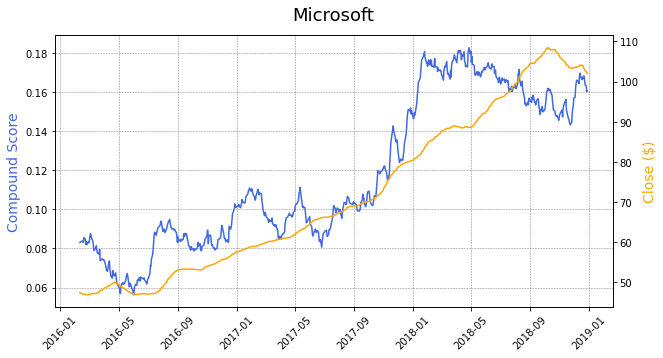

In [68]:
# plot tweets_merged_grouped 
fig,ax = plt.subplots(figsize = (10, 5))
ax.plot(tweets_merged_grouped_microsoft.date_s, 
        tweets_merged_grouped_microsoft['compound'].rolling(window=30).mean(),
        color = 'royalblue')
plt.grid(color = 'grey', linestyle = '--', linewidth = 0.5)
plt.xticks(rotation=45)
ax2 = ax.twinx()
ax2.plot(tweets_merged_grouped_microsoft['date_s'], 
            tweets_merged_grouped_microsoft['Close'].rolling(window=30).mean(),
            color = "orange")
# ax.set_xlabel('Date', fontsize=16)
ax.set_ylabel('Compound Score', color = 'royalblue', fontsize=14)
ax2.set_ylabel('Close ($)', color = 'orange', fontsize=14)
plt.title("Microsoft", fontsize=18, pad='15.0')

plt.savefig("Microsoft.png", dpi=460)

In [69]:
# check whether all variables are distributed normally

l = list(tweets_merged_grouped_microsoft.columns.values)[1:]
counter = -1

for i in l:
    x = stats.normaltest(tweets_merged_grouped_microsoft[i][1:])
    counter = counter + 1
    if x.pvalue < 0.05: 
        print(l[counter],x.pvalue.round(3), 'TRUE')
    else: 
        print(l[counter],x.pvalue.round(3), 'FALSE')

tweet_id 0.0 TRUE
post_date 0.0 TRUE
comment_num 0.0 TRUE
retweet_num 0.0 TRUE
like_num 0.0 TRUE
compound 0.0 TRUE
engagement_score 0.0 TRUE
approval_score 0.0 TRUE
controversial_score 0.0 TRUE
compound_engagement_score 0.0 TRUE
compound_approval_score 0.0 TRUE
compound_controversial_score 0.0 TRUE
Open 0.0 TRUE
High 0.0 TRUE
Low 0.0 TRUE
Close 0.0 TRUE
Volume 0.0 TRUE
Dividends 0.0 TRUE
Stock Splits 0.0 TRUE
daily_returns 0.0 TRUE
delta_compound 0.0 TRUE


In [70]:
# correlation analysis 
corr, p_value = scipy.stats.pearsonr(tweets_merged_grouped_microsoft["delta_compound"][1:], tweets_merged_grouped_microsoft["daily_returns"][1:])

print('Correlation Coefficient:',corr.round(3))
print('P-Value:',p_value.round(3))

Correlation Coefficient: -0.077
P-Value: 0.034


In [71]:
# correlation analysis 
corr, p_value = scipy.stats.pearsonr(tweets_merged_grouped_microsoft["compound"], tweets_merged_grouped_microsoft["Close"])

print('Correlation Coefficient:',corr.round(3))
print('P-Value:',p_value)

Correlation Coefficient: 0.622
P-Value: 5.771840539886926e-82


In [72]:
# correlation analysis 
corr, p_value = scipy.stats.pearsonr(tweets_merged_grouped_microsoft["compound_engagement_score"], tweets_merged_grouped_microsoft["Close"])

print('Correlation Coefficient:',corr.round(3))
print('P-Value:',p_value)

Correlation Coefficient: 0.363
P-Value: 6.525768026657691e-25


In [73]:
# correlation analysis 
corr, p_value = scipy.stats.pearsonr(tweets_merged_grouped_microsoft["compound_approval_score"], tweets_merged_grouped_microsoft["Close"])

print('Correlation Coefficient:',corr.round(3))
print('P-Value:',p_value)

Correlation Coefficient: 0.348
P-Value: 6.368018347334996e-23


In [74]:
# correlation analysis 
corr, p_value = scipy.stats.pearsonr(tweets_merged_grouped_microsoft["compound_controversial_score"], tweets_merged_grouped_microsoft["Close"])

print('Correlation Coefficient:',corr.round(3))
print('P-Value:',p_value)

Correlation Coefficient: 0.355
P-Value: 6.590105948405816e-24


#### Check for Lag 
Does the sentiment from the previous day predictive power for the next day's daily return?

In [75]:
# check for lag

# amazon delta return (has to be one day ahead )
az_dr = tweets_merged_grouped_microsoft["Close"].shift(2)[3:]
# apple delta compound 
az_dc = tweets_merged_grouped_microsoft["compound"][3:]


# correlation analysis
corr, p_value = scipy.stats.pearsonr(az_dc, az_dr)

print('Correlation Coefficient:',corr.round(3))
print('P-Value:',p_value.round(3))

Correlation Coefficient: 0.62
P-Value: 0.0


#### Stationary Check

In [76]:
# create stationary time series
stationary_close = tweets_merged_grouped_microsoft[["Close"]].pct_change().dropna().values
stationary_compound = tweets_merged_grouped_microsoft[["compound"]].pct_change().dropna().values

# print results for close
result_close = adfuller(stationary_close)
print('ADF Statistic: %f' % result_close[0])
print('p-value: %f' % result_close[1])
print('Critical Values:')
for key, value in result_close[4].items():
	print('\t%s: %.3f' % (key, value))
    
# print results for compound
result_compound = adfuller(stationary_compound)
print('ADF Statistic: %f' % result_compound[0])
print('p-value: %f' % result_compound[1])
print('Critical Values:')
for key, value in result_compound[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -11.953613
p-value: 0.000000
Critical Values:
	1%: -3.439
	5%: -2.865
	10%: -2.569
ADF Statistic: -27.326532
p-value: 0.000000
Critical Values:
	1%: -3.439
	5%: -2.865
	10%: -2.569


#### Ganger Causality Analysis 
The Null hypothesis for grangercausalitytests is that the time series in the second column, x2, does NOT Granger cause the time series in the first column, x1. Grange causality means that past values of x2 have a statistically significant effect on the current value of x1, taking past values of x1 into account as regressors. We reject the null hypothesis that x2 does not Granger cause x1 if the pvalues are below a desired size of the test.

In [77]:
# create data 
data = tweets_merged_grouped_microsoft[["Close", "compound"]].pct_change().dropna()
# execute granger causality test
gc_res = grangercausalitytests(data, 20)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8427  , p=0.3589  , df_denom=750, df_num=1
ssr based chi2 test:   chi2=0.8461  , p=0.3577  , df=1
likelihood ratio test: chi2=0.8456  , p=0.3578  , df=1
parameter F test:         F=0.8427  , p=0.3589  , df_denom=750, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.3938  , p=0.6746  , df_denom=747, df_num=2
ssr based chi2 test:   chi2=0.7928  , p=0.6727  , df=2
likelihood ratio test: chi2=0.7924  , p=0.6729  , df=2
parameter F test:         F=0.3938  , p=0.6746  , df_denom=747, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.3299  , p=0.8038  , df_denom=744, df_num=3
ssr based chi2 test:   chi2=0.9989  , p=0.8015  , df=3
likelihood ratio test: chi2=0.9982  , p=0.8017  , df=3
parameter F test:         F=0.3299  , p=0.8038  , df_denom=744, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.4072  , p=0.8035  

> For number of lags (no zero) __1__ when p-value shows up as p=0.3589, this means that past __1__ values of __"compound"__ (jointly) __have no statistically significant effect__ on the current value of the __"Close"__ column (first column).

In [78]:
# create data 
data = tweets_merged_grouped_microsoft[["compound", "Close"]].pct_change().dropna()
# execute granger causality test
gc_res = grangercausalitytests(data, 20)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5965  , p=0.4401  , df_denom=750, df_num=1
ssr based chi2 test:   chi2=0.5989  , p=0.4390  , df=1
likelihood ratio test: chi2=0.5987  , p=0.4391  , df=1
parameter F test:         F=0.5965  , p=0.4401  , df_denom=750, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.3328  , p=0.7170  , df_denom=747, df_num=2
ssr based chi2 test:   chi2=0.6700  , p=0.7153  , df=2
likelihood ratio test: chi2=0.6697  , p=0.7154  , df=2
parameter F test:         F=0.3328  , p=0.7170  , df_denom=747, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.4303  , p=0.7314  , df_denom=744, df_num=3
ssr based chi2 test:   chi2=1.3030  , p=0.7284  , df=3
likelihood ratio test: chi2=1.3019  , p=0.7287  , df=3
parameter F test:         F=0.4303  , p=0.7314  , df_denom=744, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.3541  , p=0.8412  

> For number of lags (no zero) __1__ when p-value shows up as p=0.4402, this means that past __1__ values of __"Close"__ (jointly) __have no statistically significant effect__ on the current value of the __"compound"__ column (first column).

### Tesla Analysis

In [79]:
# group sentiment by date - APPLE ONLY
tweets_merged_grouped_tesla_a = tweets_merged[tweets_merged['ticker_symbol']=='TSLA'].groupby(pd.to_datetime(tweets_merged['date_s']).dt.date).mean()

# convert to datetime
tesla_p.date_s = pd.to_datetime(tesla_p.date_s)
tweets_merged_grouped_tesla_a.index = pd.to_datetime(tweets_merged_grouped_tesla_a.index)

# merge the two datasets
tweets_merged_grouped_tesla = pd.merge(tweets_merged_grouped_tesla_a, tesla_p, on='date_s', how='inner')

In [80]:
# create column which contains the delta 
tweets_merged_grouped_tesla["delta_compound"] = tweets_merged_grouped_tesla["compound"].pct_change()

# check data 
tweets_merged_grouped_tesla.head()

,date_s,tweet_id,post_date,comment_num,retweet_num,like_num,compound,engagement_score,approval_score,controversial_score,...,compound_controversial_score,Open,High,Low,Close,Volume,Dividends,Stock Splits,daily_returns,delta_compound
0,2015-12-30,6.822000e+17,1.451484e+09,0.152815,0.380697,0.705094,0.127411,0.001329,0.001087,0.000242,...,0.000026,47.320000,48.726002,47.133999,47.618000,18489500,0,0,NaN,NaN
1,2015-12-31,6.825670e+17,1.451572e+09,0.101754,0.182456,0.368421,0.086519,0.000713,0.000551,0.000161,...,0.000045,47.702000,48.689999,47.674000,48.001999,13575000,0,0,0.008064,-0.320946
2,2016-01-04,7.158854e+17,1.459515e+09,0.280886,0.802448,1.175991,0.137024,0.002426,0.001980,0.000445,...,0.000061,46.144001,46.276001,43.799999,44.681999,34135500,0,0,-0.069164,0.583749
3,2016-01-05,7.267944e+17,1.462116e+09,0.284483,1.706897,1.517241,0.075844,0.003678,0.003227,0.000451,...,-0.000012,45.271999,45.377998,44.000000,44.686001,15934000,0,0,0.000090,-0.446493
4,2016-01-06,7.379956e+17,1.464787e+09,0.199336,0.358804,0.538206,0.062493,0.001214,0.000898,0.000316,...,0.000027,44.000000,44.009998,43.195999,43.807999,18895500,0,0,-0.019648,-0.176027


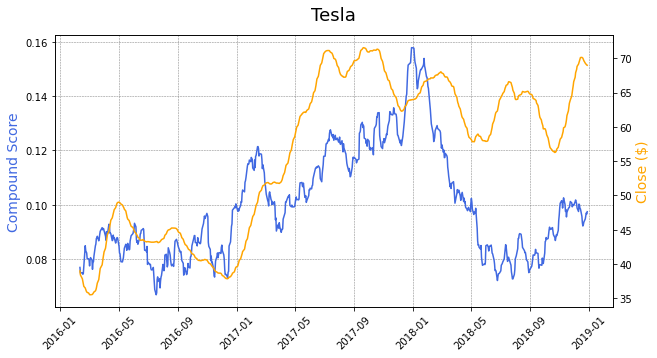

In [81]:
# plot tweets_merged_grouped 
fig,ax = plt.subplots(figsize = (10, 5))
ax.plot(tweets_merged_grouped_tesla.date_s, 
        tweets_merged_grouped_tesla['compound'].rolling(window=30).mean(),
        color = 'royalblue')
plt.grid(color = 'grey', linestyle = '--', linewidth = 0.5)
plt.xticks(rotation=45)
ax2 = ax.twinx()
ax2.plot(tweets_merged_grouped_tesla['date_s'], 
            tweets_merged_grouped_tesla['Close'].rolling(window=30).mean(),
            color = "orange")
# ax.set_xlabel('Date', fontsize=16)
ax.set_ylabel('Compound Score', color = 'royalblue', fontsize=14)
ax2.set_ylabel('Close ($)', color = 'orange', fontsize=14)
plt.title("Tesla", fontsize=18, pad='15.0')

plt.savefig("Tesla.png", dpi=460)

In [82]:
# check whether all variables are distributed normally
l = list(tweets_merged_grouped_tesla.columns.values)[1:]
counter = -1

for i in l:
    x = stats.normaltest(tweets_merged_grouped_tesla[i][1:])
    counter = counter + 1
    if x.pvalue < 0.05: 
        print(l[counter],x.pvalue.round(3), 'TRUE')
    else: 
        print(l[counter],x.pvalue.round(3), 'FALSE')

tweet_id 0.0 TRUE
post_date 0.0 TRUE
comment_num 0.0 TRUE
retweet_num 0.0 TRUE
like_num 0.0 TRUE
compound 0.0 TRUE
engagement_score 0.0 TRUE
approval_score 0.0 TRUE
controversial_score 0.0 TRUE
compound_engagement_score 0.0 TRUE
compound_approval_score 0.0 TRUE
compound_controversial_score 0.0 TRUE
Open 0.0 TRUE
High 0.0 TRUE
Low 0.0 TRUE
Close 0.0 TRUE
Volume 0.0 TRUE
Dividends 0.0 TRUE
Stock Splits 0.0 TRUE
daily_returns 0.0 TRUE
delta_compound 0.0 TRUE


In [83]:
# correlation analysis 
corr, p_value = scipy.stats.pearsonr(tweets_merged_grouped_tesla["delta_compound"][1:], tweets_merged_grouped_tesla["daily_returns"][1:])

print('Correlation Coefficient:',corr.round(3))
print('P-Value:',p_value.round(3))

Correlation Coefficient: -0.013
P-Value: 0.73


In [84]:
# correlation analysis 
corr, p_value = scipy.stats.pearsonr(tweets_merged_grouped_tesla["compound"], tweets_merged_grouped_tesla["Close"])

print('Correlation Coefficient:',corr.round(3))
print('P-Value:',p_value)

Correlation Coefficient: 0.262
P-Value: 2.346322900809937e-13


In [85]:
# correlation analysis 
corr, p_value = scipy.stats.pearsonr(tweets_merged_grouped_tesla["compound_engagement_score"], tweets_merged_grouped_tesla["Close"])

print('Correlation Coefficient:',corr.round(3))
print('P-Value:',p_value)

Correlation Coefficient: 0.296
P-Value: 1.0665510812729044e-16


In [86]:
# correlation analysis 
corr, p_value = scipy.stats.pearsonr(tweets_merged_grouped_tesla["compound_approval_score"], tweets_merged_grouped_tesla["Close"])

print('Correlation Coefficient:',corr.round(3))
print('P-Value:',p_value)

Correlation Coefficient: 0.278
P-Value: 7.151356468091566e-15


In [87]:
# correlation analysis 
corr, p_value = scipy.stats.pearsonr(tweets_merged_grouped_tesla["compound_controversial_score"], tweets_merged_grouped_tesla["Close"])

print('Correlation Coefficient:',corr.round(3))
print('P-Value:',p_value)

Correlation Coefficient: 0.316
P-Value: 5.225074529439016e-19


#### Check for Lag 
Does the sentiment from the previous day have predictive power for the next day's daily return?

In [88]:
# check for lag

# amazon delta return (has to be one day ahead )
az_dr = tweets_merged_grouped_tesla["Close"].shift(2)[3:]
# apple delta compound 
az_dc = tweets_merged_grouped_tesla["compound"][3:]


# correlation analysis
corr, p_value = scipy.stats.pearsonr(az_dc, az_dr)

print('Correlation Coefficient:',corr.round(3))
print('P-Value:',p_value.round(3))

Correlation Coefficient: 0.238
P-Value: 0.0


#### Stationary Check

In [89]:
# create stationary time series
stationary_close = tweets_merged_grouped_tesla[["Close"]].pct_change().dropna().values
stationary_compound = tweets_merged_grouped_tesla[["compound"]].pct_change().dropna().values

# print results for close
result_close = adfuller(stationary_close)
print('ADF Statistic: %f' % result_close[0])
print('p-value: %f' % result_close[1])
print('Critical Values:')
for key, value in result_close[4].items():
	print('\t%s: %.3f' % (key, value))
    
# print results for compound
result_compound = adfuller(stationary_compound)
print('ADF Statistic: %f' % result_compound[0])
print('p-value: %f' % result_compound[1])
print('Critical Values:')
for key, value in result_compound[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -28.342503
p-value: 0.000000
Critical Values:
	1%: -3.439
	5%: -2.865
	10%: -2.569
ADF Statistic: -17.116464
p-value: 0.000000
Critical Values:
	1%: -3.439
	5%: -2.865
	10%: -2.569


#### Ganger Causality Analysis 
The Null hypothesis for grangercausalitytests is that the time series in the second column, x2, does NOT Granger cause the time series in the first column, x1. Grange causality means that past values of x2 have a statistically significant effect on the current value of x1, taking past values of x1 into account as regressors. We reject the null hypothesis that x2 does not Granger cause x1 if the pvalues are below a desired size of the test.

> whether the time series in the second column Granger causes the time series in the first column.

In [90]:
# create data 
data = tweets_merged_grouped_tesla[["Close", "compound"]].pct_change().dropna()
# execute granger causality test
gc_res = grangercausalitytests(data, 20)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2399  , p=0.6244  , df_denom=750, df_num=1
ssr based chi2 test:   chi2=0.2408  , p=0.6236  , df=1
likelihood ratio test: chi2=0.2408  , p=0.6236  , df=1
parameter F test:         F=0.2399  , p=0.6244  , df_denom=750, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.1046  , p=0.9007  , df_denom=747, df_num=2
ssr based chi2 test:   chi2=0.2105  , p=0.9001  , df=2
likelihood ratio test: chi2=0.2105  , p=0.9001  , df=2
parameter F test:         F=0.1046  , p=0.9007  , df_denom=747, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.1024  , p=0.9586  , df_denom=744, df_num=3
ssr based chi2 test:   chi2=0.3102  , p=0.9581  , df=3
likelihood ratio test: chi2=0.3101  , p=0.9581  , df=3
parameter F test:         F=0.1024  , p=0.9586  , df_denom=744, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.1774  , p=0.9501  

> For number of lags (no zero) __1__ when p-value shows up as p=0.6244, this means that past __1__ values of __"compound"__ (jointly) __have no statistically significant effect__ on the current value of the __"Close"__ column (first column).

In [91]:
# create data 
data = tweets_merged_grouped_tesla[["compound", "Close"]].pct_change().dropna()
# execute granger causality test
gc_res = grangercausalitytests(data, 20)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4204  , p=0.5169  , df_denom=750, df_num=1
ssr based chi2 test:   chi2=0.4221  , p=0.5159  , df=1
likelihood ratio test: chi2=0.4220  , p=0.5160  , df=1
parameter F test:         F=0.4204  , p=0.5169  , df_denom=750, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.2802  , p=0.7557  , df_denom=747, df_num=2
ssr based chi2 test:   chi2=0.5642  , p=0.7542  , df=2
likelihood ratio test: chi2=0.5640  , p=0.7543  , df=2
parameter F test:         F=0.2802  , p=0.7557  , df_denom=747, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.2054  , p=0.8927  , df_denom=744, df_num=3
ssr based chi2 test:   chi2=0.6221  , p=0.8914  , df=3
likelihood ratio test: chi2=0.6218  , p=0.8914  , df=3
parameter F test:         F=0.2054  , p=0.8927  , df_denom=744, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.1703  , p=0.9536  

> For number of lags (no zero) __17__ when p-value shows up as p=0.1674, this means that past __17__ values of __"Close"__ (jointly) __have no statistically significant effect__ on the current value of the __"compound"__ column (first column).

# Simulation

In [92]:
# Import Stock Data for Testing Period

# apple stock data
sim_apple_p = yahoo('AAPL','2019-01-01','2019-12-31','apple_p')

# amazon stock data 
sim_amazon_p = yahoo('AMZN','2019-01-01','2019-12-31','amazon_p')

# microsoft stock data 
sim_microsoft_p = yahoo('MSFT','2019-01-01','2019-12-31','microsoft_p')

# tesla stock data 
sim_tesla_p = yahoo('TSLA','2019-01-01','2019-12-31','tesla_p')

In [93]:
def grouped_df_simulation(sim_tweets_df, sim_stock_df):
    # merge the two datasets
    df = pd.merge(sim_tweets_df, sim_stock_df, on='date_s', how='inner')

    # calculate percentage change 
    df['compound_pct'] = df['compound'].pct_change()

    # calculate percentage change 
    df['close_pct'] = df['Close'].pct_change()
    
    return df

In [94]:
# create rolling dataframe
def create_rolling_df(df, window, df1):
    
    # define benchmark one std of previous mean
    benchmark = df1['compound'].rolling(window=window).mean().std()
    
    # define benchmark mean of previous rolling_pct_change
    benchmark2 = df1['compound'].rolling(window=window).mean().pct_change().mean()
    
    # define benchmark mean of previous compound
    benchmark3 = df1['compound'].rolling(window=window).mean().mean()
    
    
    
    
    # create rolling average column 
    rolling_compound = df['compound'].rolling(window=window).mean()
    # create percentage change of rolling average column 
    rolling_pct_change = rolling_compound.pct_change()
    # append the new columns
    df['rolling_compound'] = rolling_compound
    df['rolling_pct_change'] = rolling_pct_change
    
    # initilize signal list 
    signal = []

    for i, value in enumerate(df['rolling_pct_change']): 
        if value >= 0:
            signal.append('Buy')
        elif value < 0: 
            signal.append('Sell')
    # since rolling_pct_change has NA's we need one neutral signal for those rows in order to have the same length
        else:
            signal.append('/')
    
    df['signal'] = signal
    
    return df

In [95]:
# brute force version
# only considers buying signals

def simulation(df):
    strategy = 100
    
    # buy_hold means we buy and hold the stock in the given period
    buy_hold = ((df['Close'][len(df)-1]/df['Close'][0]))*100

    for num, value in enumerate(df['signal']): 
        # num has to be smaller than the length of the df -1 because of num + 1 in the if clause 
        if value == 'Buy' and num < len(df)-1:
            # we get the percentage change if we buy 
            # when the signal is Sell, then nothing happens to our Portfolio since we are not owning the stock anymore
            strategy = strategy * (1+df['close_pct'][num+1])
    return print("Sentiment Strategy:", strategy, "\n", "Buy And Hold:", buy_hold)

In [96]:
def sim_visualization(df,title):
    buy_signal = []
    sell_signal = []
    hold_last_signal = []

    for i in range(len(df)):
        if df['signal'][i] == 'Buy':
            buy_signal.append(df['Close'][i])
            sell_signal.append(float('nan'))
            hold_last_signal.append(float('nan'))
        elif df['signal'][i] == 'Sell':
            sell_signal.append(df['Close'][i])
            buy_signal.append(float('nan'))
            hold_last_signal.append(float('nan'))
        else:
            hold_last_signal.append(df['Close'][i])
            buy_signal.append(float('nan'))
            sell_signal.append(float('nan'))


    df['buy_signal'] = buy_signal
    df['sell_signal'] = sell_signal
    df['hold_last_signal'] = hold_last_signal

        # example plot
    fig = plt.subplots(figsize = (20, 10))
    plt.plot(df['Close'], alpha = 0.5)
    plt.scatter(df.index, df['buy_signal'], marker='^', color='green')
    plt.scatter(df.index, df['sell_signal'], marker='v', color='red')
    plt.scatter(df.index, df['hold_last_signal'], marker='D', color='blue')
    plt.title("{} Simulation".format(title))
    plt.show()

## Apple Simulation

In [97]:
# group df
apple_grouped_sim = grouped_df_simulation(tweets_merged_grouped_apple_a, sim_apple_p)

# define lag
# 12, 13, 14, 15, 16, 17
lag = 17

# create signals and other new columns 
apple_grouped_sim = create_rolling_df(apple_grouped_sim, lag, tweets_merged_grouped_apple_a)
apple_grouped_sim = apple_grouped_sim.reset_index()

# simulate the strategy based on the signals 
simulation(apple_grouped_sim)

Sentiment Strategy: 131.6168438151859 
 Buy And Hold: 187.5872358001127


In [98]:
# visualize simulation
# sim_visualization(apple_grouped_sim, 'Apple')

##  Amazon Simulation

In [99]:
# group df
amazon_grouped_sim = grouped_df_simulation(tweets_merged_grouped_amazon_a, sim_amazon_p)

# define lag
lag = 15

# create signals and other new columns 
amazon_grouped_sim = create_rolling_df(amazon_grouped_sim, lag,tweets_merged_grouped_amazon_a)
amazon_grouped_sim = amazon_grouped_sim.reset_index()

# simulate the strategy based on the signals 
simulation(amazon_grouped_sim)

Sentiment Strategy: 118.4949181053018 
 Buy And Hold: 122.96450998842828


In [100]:
# visualize simulation
# sim_visualization(amazon_grouped_sim, 'Amazon')

##  Microsoft Simulation

In [101]:
# group df
microsoft_grouped_sim = grouped_df_simulation(tweets_merged_grouped_microsoft_a, sim_microsoft_p)

# define lag
lag = 5

# create signals and other new columns 
microsoft_grouped_sim = create_rolling_df(microsoft_grouped_sim, lag, tweets_merged_grouped_microsoft_a)
microsoft_grouped_sim = microsoft_grouped_sim.reset_index()

# simulate the strategy based on the signals 
simulation(microsoft_grouped_sim)

Sentiment Strategy: 111.88300671112394 
 Buy And Hold: 157.44818206411398


##  Tesla Simulation

In [102]:
# group df
tesla_grouped_sim = grouped_df_simulation(tweets_merged_grouped_tesla_a, sim_tesla_p)

# define lag
lag = 4

# create signals and other new columns 
tesla_grouped_sim = create_rolling_df(tesla_grouped_sim, lag, tweets_merged_grouped_tesla_a)
tesla_grouped_sim = tesla_grouped_sim.reset_index()

# simulate the strategy based on the signals 
simulation(tesla_grouped_sim)

Sentiment Strategy: 199.0079685458226 
 Buy And Hold: 124.60938323862307


# Validating

> __Why do the simulations perform so badly?__
>> Hypothesis: The pattern that were detected previously did not withstand into the new period.

## Apple

In [103]:
# create data 
data = apple_grouped_sim[["Close", "compound"]].pct_change().dropna()
# execute granger causality test
gc_res = grangercausalitytests(data, 20)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7682  , p=0.3816  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.7776  , p=0.3779  , df=1
likelihood ratio test: chi2=0.7764  , p=0.3783  , df=1
parameter F test:         F=0.7682  , p=0.3816  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.4411  , p=0.6439  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=0.9002  , p=0.6376  , df=2
likelihood ratio test: chi2=0.8986  , p=0.6381  , df=2
parameter F test:         F=0.4411  , p=0.6439  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.9366  , p=0.4236  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=2.8915  , p=0.4087  , df=3
likelihood ratio test: chi2=2.8748  , p=0.4113  , df=3
parameter F test:         F=0.9366  , p=0.4236  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.6867  , p=0.6018  

In [104]:
# create data 
data = apple_grouped_sim[["compound", "Close"]].pct_change().dropna()
# execute granger causality test
gc_res = grangercausalitytests(data, 20)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0029  , p=0.9569  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0030  , p=0.9566  , df=1
likelihood ratio test: chi2=0.0030  , p=0.9566  , df=1
parameter F test:         F=0.0029  , p=0.9569  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0086  , p=0.9914  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=0.0175  , p=0.9913  , df=2
likelihood ratio test: chi2=0.0175  , p=0.9913  , df=2
parameter F test:         F=0.0086  , p=0.9914  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=5.2038  , p=0.0017  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=16.0649 , p=0.0011  , df=3
likelihood ratio test: chi2=15.5660 , p=0.0014  , df=3
parameter F test:         F=5.2038  , p=0.0017  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.9022  , p=0.0043  

## Amazon 

In [105]:
# create data 
data = amazon_grouped_sim[["Close", "compound"]].pct_change().dropna()
# execute granger causality test
gc_res = grangercausalitytests(data, 20)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.7055  , p=0.0554  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=3.7505  , p=0.0528  , df=1
likelihood ratio test: chi2=3.7227  , p=0.0537  , df=1
parameter F test:         F=3.7055  , p=0.0554  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.3502  , p=0.0975  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=4.7966  , p=0.0909  , df=2
likelihood ratio test: chi2=4.7510  , p=0.0930  , df=2
parameter F test:         F=2.3502  , p=0.0975  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.5280  , p=0.2078  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=4.7171  , p=0.1937  , df=3
likelihood ratio test: chi2=4.6728  , p=0.1974  , df=3
parameter F test:         F=1.5280  , p=0.2078  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.3161  , p=0.2646  

In [106]:
# create data 
data = amazon_grouped_sim[["compound", "Close"]].pct_change().dropna()
# execute granger causality test
gc_res = grangercausalitytests(data, 20)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.0383  , p=0.0456  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=4.0873  , p=0.0432  , df=1
likelihood ratio test: chi2=4.0543  , p=0.0441  , df=1
parameter F test:         F=4.0383  , p=0.0456  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.2859  , p=0.2783  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=2.6244  , p=0.2692  , df=2
likelihood ratio test: chi2=2.6107  , p=0.2711  , df=2
parameter F test:         F=1.2859  , p=0.2783  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.9612  , p=0.4117  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=2.9673  , p=0.3967  , df=3
likelihood ratio test: chi2=2.9497  , p=0.3994  , df=3
parameter F test:         F=0.9612  , p=0.4117  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.1089  , p=0.3530  

## Microsoft

In [107]:
# create data 
data = microsoft_grouped_sim[["Close", "compound"]].pct_change().dropna()
# execute granger causality test
gc_res = grangercausalitytests(data, 20)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3348  , p=0.5634  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.3389  , p=0.5605  , df=1
likelihood ratio test: chi2=0.3387  , p=0.5606  , df=1
parameter F test:         F=0.3348  , p=0.5634  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.2583  , p=0.7726  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=0.5271  , p=0.7683  , df=2
likelihood ratio test: chi2=0.5265  , p=0.7685  , df=2
parameter F test:         F=0.2583  , p=0.7726  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.1844  , p=0.9070  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=0.5692  , p=0.9034  , df=3
likelihood ratio test: chi2=0.5686  , p=0.9036  , df=3
parameter F test:         F=0.1844  , p=0.9070  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.5754  , p=0.1815  

In [108]:
# create data 
data = microsoft_grouped_sim[["compound", "Close"]].pct_change().dropna()
# execute granger causality test
gc_res = grangercausalitytests(data, 20)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6331  , p=0.4270  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.6407  , p=0.4234  , df=1
likelihood ratio test: chi2=0.6399  , p=0.4237  , df=1
parameter F test:         F=0.6331  , p=0.4270  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.3362  , p=0.7148  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=0.6861  , p=0.7096  , df=2
likelihood ratio test: chi2=0.6851  , p=0.7099  , df=2
parameter F test:         F=0.3362  , p=0.7148  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.2164  , p=0.8850  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=0.6681  , p=0.8807  , df=3
likelihood ratio test: chi2=0.6672  , p=0.8809  , df=3
parameter F test:         F=0.2164  , p=0.8850  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.2164  , p=0.9292  

## Tesla 

In [109]:
# create data 
data = tesla_grouped_sim[["Close", "compound"]].pct_change().dropna()
# execute granger causality test
gc_res = grangercausalitytests(data, 20)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1673  , p=0.6828  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.1694  , p=0.6807  , df=1
likelihood ratio test: chi2=0.1693  , p=0.6807  , df=1
parameter F test:         F=0.1673  , p=0.6828  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.4800  , p=0.0858  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=5.0617  , p=0.0796  , df=2
likelihood ratio test: chi2=5.0110  , p=0.0816  , df=2
parameter F test:         F=2.4800  , p=0.0858  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.0284  , p=0.1105  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=6.2619  , p=0.0995  , df=3
likelihood ratio test: chi2=6.1842  , p=0.1030  , df=3
parameter F test:         F=2.0284  , p=0.1105  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.4752  , p=0.2104  

In [110]:
# create data 
data = tesla_grouped_sim[["compound", "Close"]].pct_change().dropna()
# execute granger causality test
gc_res = grangercausalitytests(data, 20)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.6037  , p=0.1079  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.6354  , p=0.1045  , df=1
likelihood ratio test: chi2=2.6216  , p=0.1054  , df=1
parameter F test:         F=2.6037  , p=0.1079  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.1414  , p=0.3211  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=2.3296  , p=0.3120  , df=2
likelihood ratio test: chi2=2.3187  , p=0.3137  , df=2
parameter F test:         F=1.1414  , p=0.3211  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.5761  , p=0.1958  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=4.8655  , p=0.1819  , df=3
likelihood ratio test: chi2=4.8184  , p=0.1856  , df=3
parameter F test:         F=1.5761  , p=0.1958  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.5385  , p=0.1917  

# The Following Content was not Included in the Bachelor Thesis Results

***

# Linear Regression

coefficient of determination: 0.5329013829681182
intercept: 23.531587504162324
slope: [84.6169424]


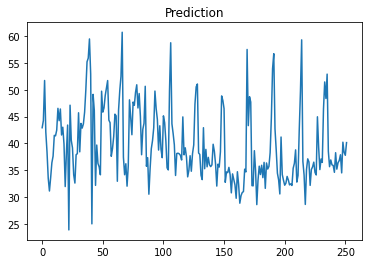

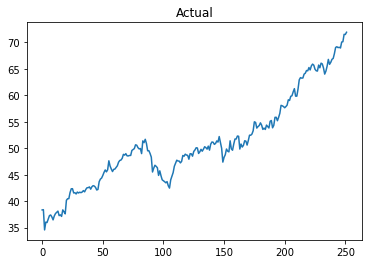

In [111]:
x = np.array(tweets_merged_grouped_apple.compound).reshape((-1, 1))
y = np.array(tweets_merged_grouped_apple.Close)

model = LinearRegression().fit(x, y)

r_sq = model.score(x, y)
print('coefficient of determination:', r_sq)
print('intercept:', model.intercept_)
print('slope:', model.coef_)


x2 = np.array(apple_grouped_sim.compound).reshape((-1, 1))
y_pred = model.predict(x2)

plt.plot(y_pred)
plt.title('Prediction')
plt.show()

plt.plot(apple_grouped_sim.Close)
plt.title('Actual')
plt.show()

# Vector Autoregression

1. You need at least two time series (variables)
2. The time series should influence each other.

It is considered as an Autoregressive model because, each variable (Time Series) is modeled as a function of the past values, that is the predictors are nothing but the lags (time delayed value) of the series.


Ok, so how is VAR different from other Autoregressive models like AR, ARMA or ARIMA?

The primary difference is those models are uni-directional, where, the predictors influence the Y and not vice-versa. Whereas, Vector Auto Regression (VAR) is bi-directional. That is, the variables influence each other.

In [112]:
# split into test and training data set
# tweets_merged_grouped_apple.set_index('date_s', inplace=True)
train_data_apple = tweets_merged_grouped_apple[['compound','Close']].astype('float').pct_change().dropna()

# apple_grouped_sim.set_index('date_s', inplace=True)
test_data_apple = apple_grouped_sim[['compound','Close']].astype('float').pct_change().dropna()

print(test_data_apple.shape, train_data_apple.shape)
print(test_data_apple, train_data_apple)

(251, 2) (754, 2)
     compound     Close
1    0.069206  0.001141
2    0.359160 -0.099607
3   -0.340969  0.042689
4   -0.199463 -0.002226
5   -0.327770  0.019063
..        ...       ...
247 -0.234990  0.016318
248  0.520489  0.000951
249 -0.113218  0.019840
250 -0.037327 -0.000380
251  0.165852  0.005935

[251 rows x 2 columns]      compound     Close
1   -0.241428 -0.019195
2    1.242863  0.000855
3   -0.405840 -0.025059
4   -0.182408 -0.019570
5   -0.991254 -0.042204
..        ...       ...
750  0.244182 -0.038896
751  0.204128 -0.025874
752  0.469941  0.070422
753 -0.251067 -0.006490
754  0.229908  0.000512

[754 rows x 2 columns]


In [113]:
# --- VARMAX --- 

# Train

# 12 = the number of lags; 0 means no moving averages; 
var_max_model = VARMAX(train_data_apple, order=(12,0))
fitted_model = var_max_model.fit()
print(fitted_model.summary())

/Users/pietj.ginski/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/pietj.ginski/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                             Statespace Model Results                            
Dep. Variable:     ['compound', 'Close']   No. Observations:                  754
Model:                           VAR(12)   Log Likelihood                -796.083
                             + intercept   AIC                           1698.165
Date:                   Sat, 23 Oct 2021   BIC                           1943.311
Time:                           13:48:03   HQIC                          1792.602
Sample:                                0                                         
                                   - 754                                         
Covariance Type:                     opg                                         
Ljung-Box (L1) (Q):             0.00, 0.04   Jarque-Bera (JB):   1222910.40, 297.31
Prob(Q):                        0.95, 0.84   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         0.17, 1.69   Skew:                       5.53, 0.10
Prob(H) (t

In [114]:
# Test
n_forecast = 50
predict = fitted_model.get_prediction()

predictions = predict.predicted_mean
predictions.columns = ['compound','Close']


predictions

# test_vs_pred = pd.concat([test_data_apple,predictions],axis=1)

# test_vs_pred.plot(figsize=(12,5))
# predictions.plot()

,compound,Close
1,0.466966,0.000986
2,2.282461,0.000202
3,0.827674,0.000068
4,3.857114,0.002057
5,2.808949,-0.002405
...,...,...
750,1.429289,-0.002677
751,-5.175035,0.003417
752,2.184160,-0.006003
753,4.436338,0.007533


/Users/pietj.ginski/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


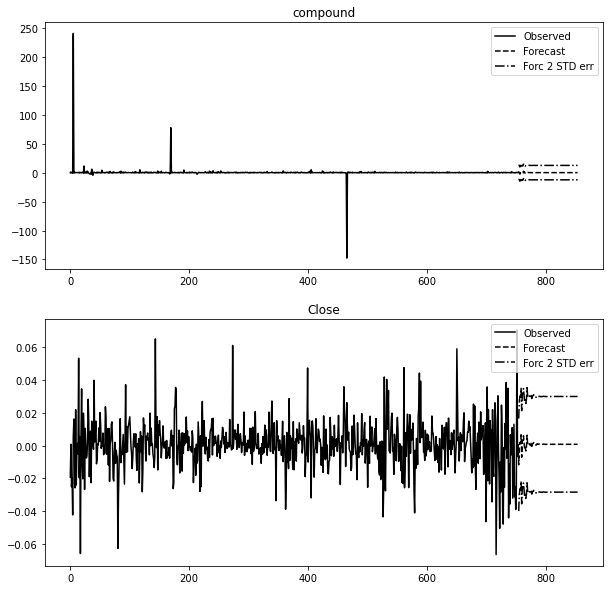

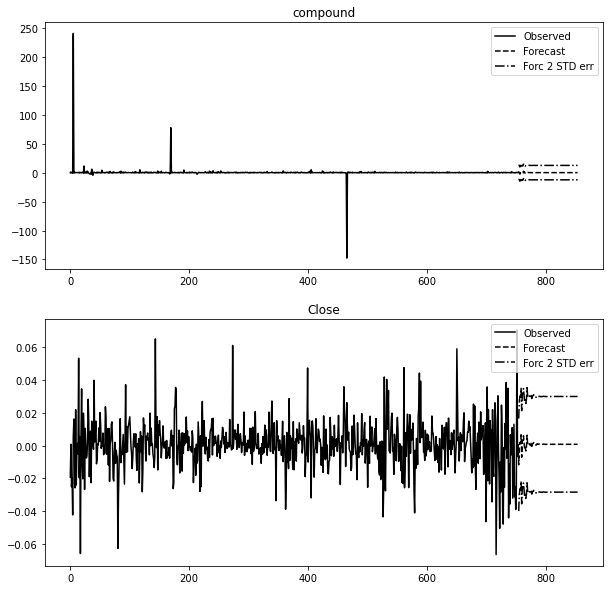

In [115]:
# --- VAR ---

model = VAR(train_data_apple)
model_fit = model.fit(maxlags=17)
model_fit.summary()

# Forecast

# derive lag from model_fit
lag_order = model_fit.k_ar

# model input 
forecast_input = np.array(test_data_apple.values[-lag_order:])

# build the forecast
fc = model_fit.forecast(forecast_input, steps=12)

# plot forecast
model_fit.plot_forecast(100)